Création du dataset

In [34]:
#Je met les liens des images d'un coté et le folder + id de l'autre
import tensorflow as tf
import mlflow

base_path = '/Users/orphila_adjovi/PJT6_Open_classrooms_MLE/Images'

image_size = (224, 224)  # Taille images
batch_size = 120  # Taille de lot

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.4,
    subset="training",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.4,
    subset="validation",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)


all_classes = train_ds.class_names
print("Noms des sous-dossiers (class_names) :", all_classes)

test_ds = val_ds.take(len(val_ds) // 2)
val_ds = val_ds.skip(len(val_ds) // 2)

# Vérification des dimensions
print("Dimensions de train_ds :", len(train_ds))
print("Dimensions de val_ds :", len(val_ds))
print("Dimensions de test_ds :", len(test_ds))

Found 20580 files belonging to 120 classes.
Using 12348 files for training.
Found 20580 files belonging to 120 classes.
Using 8232 files for validation.
Noms des sous-dossiers (class_names) : ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093

Création de l'échantillon

In [35]:
import numpy as np

path_2 = '/Users/orphila_adjovi/PJT6_Open_classrooms_MLE/img'

train_ds_sample = tf.keras.utils.image_dataset_from_directory(
    path_2,
    validation_split=0.4,
    subset="training",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds_sample = tf.keras.utils.image_dataset_from_directory(
    path_2,
    validation_split=0.4,
    subset="validation",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

sample_classes = train_ds_sample.class_names
print("Noms des sous-dossiers (class_names) :", sample_classes)

test_ds_sample = val_ds_sample.take(len(val_ds_sample) // 2)
val_ds_sample = val_ds_sample.skip(len(val_ds_sample) // 2)

def get_class_proportions(dataset):
    all_labels = []
    for _, labels in dataset.as_numpy_iterator():
        all_labels.extend(labels)

    unique_labels, label_counts = np.unique(all_labels, return_counts=True)
    total_samples = len(all_labels)
    class_proportions = {label: round(count / total_samples,2)*100 for label, count in zip(unique_labels, label_counts)}

    return class_proportions

train_class_proportions = get_class_proportions(train_ds_sample)
print("Proportion des classes dans l'ensemble d'entraînement :", train_class_proportions)
val_class_proportions = get_class_proportions(val_ds_sample)
print("Proportion des classes dans l'ensemble de validation :", val_class_proportions)
test_class_proportions = get_class_proportions(test_ds_sample)
print("Proportion des classes dans l'ensemble de test :", test_class_proportions)

Found 497 files belonging to 3 classes.
Using 299 files for training.
Found 497 files belonging to 3 classes.
Using 198 files for validation.
Noms des sous-dossiers (class_names) : ['n02085620-Chihuahua', 'n02088364-beagle', 'n02099601-golden_retriever']
Proportion des classes dans l'ensemble d'entraînement : {0: 30.0, 1: 40.0, 2: 28.999999999999996}
Proportion des classes dans l'ensemble de validation : {0: 32.0, 1: 40.0, 2: 28.000000000000004}
Proportion des classes dans l'ensemble de test : {0: 30.0, 1: 44.0, 2: 26.0}


Création des modèles de transfer learning

In [36]:
# Fonctions de prétraitement
from tensorflow.keras import layers
import numpy as np
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

def apply_noise(image):
    image_np = image.numpy()
    noise_factor = np.random.uniform(0, 100)
    noise = np.random.normal(loc=0, scale=noise_factor, size=image_np.shape)
    noisy_image_np = image_np + noise
    noisy_image_np = np.clip(noisy_image_np, 0, 255)
    return tf.convert_to_tensor(noisy_image_np, dtype=tf.float32)

def data_augmentation_2(images):
    return tf.map_fn(apply_noise, images, dtype=tf.float32)

#Scaling du nombre de pixels 
def data_standardisation(images):
    """output = (input-offset)/scale, offset à zéro"""
    images = layers.Rescaling(scale=1.5)(images)
    return images

def convert_to_grayscale(images):
    if images.shape[-1] == 3:
        grayscale_images = tf.image.rgb_to_grayscale(images)
        return grayscale_images
    else:
        return images

In [37]:
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam


# Modèle pré-entraîné ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Congeler les couches du modèle de base
base_model.trainable = False

# Définition de la fonction objective pour l'optimisation avec Optuna
def objective(trial):
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    num_epochs = trial.suggest_int('num_epochs', 5, 10)

    model = Sequential([
        #layers.Lambda(convert_to_grayscale),
        #layers.Lambda(data_standardisation),
        #layers.Lambda(data_augmentation),
        #Conv2D(64, (kernel_size, kernel_size), activation='relu'),
        #layers.MaxPooling2D((2, 2)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(120, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds_sample, validation_data=val_ds_sample, epochs=num_epochs, callbacks=[TFKerasPruningCallback(trial, 'accuracy')])

    return history.history['accuracy'][-1]

# Création de l'étude Optuna et lancement de l'optimisation
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Affichage des meilleurs hyperparamètres
best_params = study.best_params
print("Meilleurs hyperparamètres:", best_params)



[I 2024-02-09 17:50:55,977] A new study created in memory with name: no-name-f2befc74-2af1-48b2-8887-8553e7af649f


Epoch 1/6
3/3 [==============================] - 104s 14s/step - loss: 8.2485 - accuracy: 0.2508 - val_loss: 43.1437 - val_accuracy: 0.2308
Epoch 2/6
3/3 [==============================] - 33s 11s/step - loss: 26.9355 - accuracy: 0.3177 - val_loss: 8.1455 - val_accuracy: 0.2821
Epoch 3/6
3/3 [==============================] - 36s 12s/step - loss: 4.4569 - accuracy: 0.4448 - val_loss: 1.7626 - val_accuracy: 0.5641
Epoch 4/6
3/3 [==============================] - 35s 12s/step - loss: 1.8471 - accuracy: 0.5084 - val_loss: 0.6466 - val_accuracy: 0.8077
Epoch 5/6
3/3 [==============================] - 32s 13s/step - loss: 0.5214 - accuracy: 0.7826 - val_loss: 0.4385 - val_accuracy: 0.8974
Epoch 6/6
3/3 [==============================] - 36s 12s/step - loss: 0.4971 - accuracy: 0.8328 - val_loss: 0.1453 - val_accuracy: 0.9487


[I 2024-02-09 17:55:33,498] Trial 0 finished with value: 0.832775890827179 and parameters: {'dropout_rate': 0.12455532117359902, 'kernel_size': 3, 'learning_rate': 0.00552256799775428, 'num_epochs': 6}. Best is trial 0 with value: 0.832775890827179.


Epoch 1/6
2/3 [===================>..........] - ETA: 6s - loss: 6.9938 - accuracy: 0.1917 

[W 2024-02-09 17:56:09,258] Trial 1 failed with parameters: {'dropout_rate': 0.47126344325044234, 'kernel_size': 3, 'learning_rate': 0.006892711551103231, 'num_epochs': 6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/orphila_adjovi/PJT6_Open_classrooms_MLE/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/_l/cjjst_c50lx2nkkr280zbp440000gp/T/ipykernel_1606/1914235648.py", line 41, in objective
    history = model.fit(train_ds_sample, validation_data=val_ds_sample, epochs=num_epochs, callbacks=[TFKerasPruningCallback(trial, 'accuracy')])
  File "/Users/orphila_adjovi/PJT6_Open_classrooms_MLE/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/Users/orphila_adjovi/PJT6_Open_classrooms_MLE/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", lin

KeyboardInterrupt: 

Construction du resnet

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_model(mdl, train_ens, val_ens, test_ens, optimizer,name):
    class_ens = train_ens.class_names
    mdl.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    # Commencer une expérience MLflow
    with mlflow.start_run(run_name=name):
        mlflow.tensorflow.log_model(
            keras_model=mdl,
            artifact_path='model',
            registered_model_name="cnn "+name,
        )
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("epochs", 3)


        mdl.fit(train_ens, validation_data=val_ens, epochs=3)
        # Prédiction pour l'ensemble de test
        y_pred = mdl.predict(test_ens)
        # Convertir les prédictions en classes
        y_pred_classes = np.argmax(y_pred, axis=1)
        # Convertir les étiquettes de l'ensemble de test en classes
        y_true = np.concatenate([y for x, y in test_ens], axis=0)
        """
        # Calculer la matrice de confusion
        cm = confusion_matrix(y_true, y_pred_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, cmap="Reds",xticklabels=class_ens, yticklabels=class_ens)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Matrice de Confusion - Ensemble de Test')
        plt.show()
        """
        # Évaluer l'exactitude sur l'ensemble de test
        accuracy = mdl.evaluate(test_ens, verbose=0)[1]
        print(f"Précision sur le test: {accuracy}")
        mlflow.log_metric("accuracy", accuracy)

model_3 = Sequential([
    #layers.Lambda(convert_to_grayscale),
    #layers.Lambda(data_standardisation),
    #ayers.Lambda(data_augmentation),
    #Conv2D(64, (best_params['kernel_size'], best_params['kernel_size']), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(best_params['dropout_rate']),
    layers.Dense(256, activation='relu'),
    layers.Dropout(best_params['dropout_rate']),
    layers.Dense(120, activation='softmax')
])

cnn_from_ResNet50 = train_model(model_3,train_ds_sample,val_ds_sample,test_ds_sample,Adam(learning_rate=best_params['learning_rate']),"cnn_from_ResNet50")

Epoch 1/10
3/3 [==============================] - 30s 8s/step - loss: 3.0821 - accuracy: 0.3244 - val_loss: 2.1007 - val_accuracy: 0.5513
Epoch 2/10
3/3 [==============================] - 23s 8s/step - loss: 1.5699 - accuracy: 0.5987 - val_loss: 1.0784 - val_accuracy: 0.6282
Epoch 3/10
3/3 [==============================] - 24s 8s/step - loss: 0.6703 - accuracy: 0.7458 - val_loss: 0.7131 - val_accuracy: 0.7051
Epoch 4/10
3/3 [==============================] - 22s 7s/step - loss: 0.4980 - accuracy: 0.8060 - val_loss: 0.3065 - val_accuracy: 0.8974
Epoch 5/10
3/3 [==============================] - 23s 8s/step - loss: 0.2582 - accuracy: 0.8963 - val_loss: 0.2471 - val_accuracy: 0.9359
Epoch 6/10
3/3 [==============================] - 23s 8s/step - loss: 0.1842 - accuracy: 0.9264 - val_loss: 0.1630 - val_accuracy: 0.9744
Epoch 7/10
3/3 [==============================] - 21s 7s/step - loss: 0.1281 - accuracy: 0.9599 - val_loss: 0.1163 - val_accuracy: 0.9487
Epoch 8/10
3/3 [==================

1/1 [==============================] - 7s 7s/step
[<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([1, 2, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 2, 2, 0, 1, 0,
       2, 0, 0, 2, 2, 1, 0, 2, 2, 0, 1, 2, 1, 1, 2, 1, 0, 2, 2, 0, 0, 2,
       1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1,
       1, 2, 0, 1, 1, 0, 2, 0, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1, 2, 0,
       0, 2, 2, 1, 1, 1, 2, 0, 1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1,
       1, 1, 0, 1, 2, 1, 0, 0, 2, 1], dtype=int32)>]
[0 0 0 1 2 2 2 2 1 0 0 1 1 2 1 1 2 1 0 2 1 2 0 1 1 0 1 1 2 2 0 1 1 0 1 1 2
 1 2 1 2 2 0 1 0 0 0 2 0 2 2 2 2 0 0 1 1 0 2 1 0 1 1 2 2 1 1 1 2 2 1 1 0 0
 0 1 1 2 0 2 0 1 0 2 1 1 1 1 1 2 0 0 0 1 1 0 0 2 2 2 0 0 1 2 2 1 1 2 2 0 1
 0 0 0 2 1 0 0 2 1]
1/1 [==============================] - 7s 7s/step - loss: 0.0673 - accuracy: 0.9667
[0.06730203330516815, 0.9666666388511658]


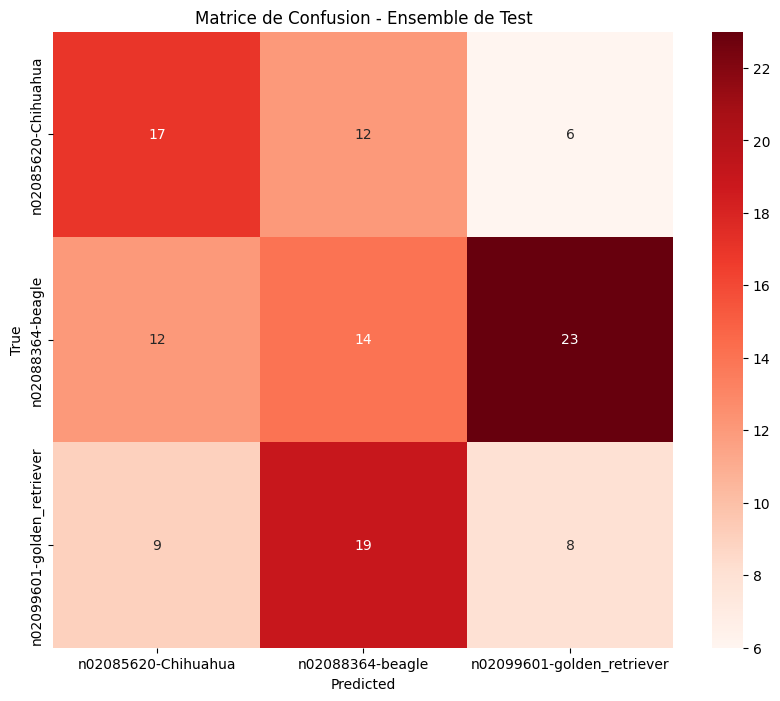

Précision sur le test: [0.15639667212963104, 0.9666666388511658]


In [ ]:
"""
test_ens = test_ds_sample
class_ens = train_ds_sample.class_names

# Prédiction pour l'ensemble de test
y_pred = mdl3.predict(test_ens)
# Convertir les prédictions en classes
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ens], axis=0)
print([y for x, y in test_ens])
print(y_pred_classes)
# Calculer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Reds", xticklabels=class_ens, yticklabels=class_ens)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de Confusion - Ensemble de Test')
plt.show()

accuracy = mdl3.evaluate(test_ens, verbose=0)
print(f"Précision sur le test: {accuracy}")
"""

Construction du vgg16

[I 2024-02-03 02:53:01,193] A new study created in memory with name: no-name-f12a6aa2-4bb9-4bb7-9cc2-7ba714748005


Epoch 1/7
3/3 [==============================] - 39s 12s/step - loss: 29.2822 - accuracy: 0.2475 - val_loss: 51.9229 - val_accuracy: 0.3333
Epoch 2/7
3/3 [==============================] - 44s 16s/step - loss: 28.0283 - accuracy: 0.4415 - val_loss: 3.4860 - val_accuracy: 0.5513
Epoch 3/7
3/3 [==============================] - 44s 14s/step - loss: 3.1851 - accuracy: 0.4883 - val_loss: 0.6401 - val_accuracy: 0.6154
Epoch 4/7
3/3 [==============================] - 42s 15s/step - loss: 1.5499 - accuracy: 0.6221 - val_loss: 0.3471 - val_accuracy: 0.8462
Epoch 5/7
3/3 [==============================] - 53s 17s/step - loss: 0.6290 - accuracy: 0.7191 - val_loss: 0.3372 - val_accuracy: 0.8846
Epoch 6/7
3/3 [==============================] - 39s 13s/step - loss: 0.6007 - accuracy: 0.7559 - val_loss: 0.3028 - val_accuracy: 0.8974
Epoch 7/7
3/3 [==============================] - 40s 14s/step - loss: 0.3869 - accuracy: 0.8696 - val_loss: 0.2676 - val_accuracy: 0.8974


[I 2024-02-03 02:58:02,159] Trial 0 finished with value: 0.8695651888847351 and parameters: {'dropout_rate': 0.3934742023714427, 'kernel_size': 5, 'learning_rate': 0.00883939253978634, 'num_epochs': 7}. Best is trial 0 with value: 0.8695651888847351.


Epoch 1/7
3/3 [==============================] - 42s 14s/step - loss: 13.9774 - accuracy: 0.2441 - val_loss: 13.3472 - val_accuracy: 0.4487
Epoch 2/7
3/3 [==============================] - 41s 14s/step - loss: 9.9784 - accuracy: 0.4783 - val_loss: 3.5353 - val_accuracy: 0.5641
Epoch 3/7
3/3 [==============================] - 41s 14s/step - loss: 3.7702 - accuracy: 0.5619 - val_loss: 0.3579 - val_accuracy: 0.8590
Epoch 4/7
3/3 [==============================] - 46s 16s/step - loss: 1.3122 - accuracy: 0.7124 - val_loss: 0.8161 - val_accuracy: 0.7436
Epoch 5/7
3/3 [==============================] - 42s 14s/step - loss: 0.9489 - accuracy: 0.7592 - val_loss: 0.2128 - val_accuracy: 0.9231
Epoch 6/7
3/3 [==============================] - 42s 14s/step - loss: 0.5293 - accuracy: 0.8227 - val_loss: 0.2840 - val_accuracy: 0.8974
Epoch 7/7
3/3 [==============================] - 42s 15s/step - loss: 0.6268 - accuracy: 0.8261 - val_loss: 0.2682 - val_accuracy: 0.9231


[I 2024-02-03 03:02:58,211] Trial 1 finished with value: 0.8260869383811951 and parameters: {'dropout_rate': 0.4423951661722071, 'kernel_size': 5, 'learning_rate': 0.0036118595351184502, 'num_epochs': 7}. Best is trial 0 with value: 0.8695651888847351.


Epoch 1/6
3/3 [==============================] - 43s 14s/step - loss: 33.6757 - accuracy: 0.2441 - val_loss: 115.3518 - val_accuracy: 0.2949
Epoch 2/6
3/3 [==============================] - 42s 14s/step - loss: 67.1759 - accuracy: 0.3344 - val_loss: 4.6530 - val_accuracy: 0.6154
Epoch 3/6
3/3 [==============================] - 42s 15s/step - loss: 6.1680 - accuracy: 0.4883 - val_loss: 2.7429 - val_accuracy: 0.6026
Epoch 4/6
3/3 [==============================] - 43s 14s/step - loss: 2.2948 - accuracy: 0.5552 - val_loss: 1.1022 - val_accuracy: 0.5769
Epoch 5/6
3/3 [==============================] - 38s 12s/step - loss: 1.3872 - accuracy: 0.5619 - val_loss: 0.3526 - val_accuracy: 0.8718
Epoch 6/6
3/3 [==============================] - 37s 12s/step - loss: 0.7939 - accuracy: 0.7224 - val_loss: 0.3222 - val_accuracy: 0.8846


[I 2024-02-03 03:07:03,368] Trial 2 finished with value: 0.7224080562591553 and parameters: {'dropout_rate': 0.22514398077783926, 'kernel_size': 5, 'learning_rate': 0.008637892794729487, 'num_epochs': 6}. Best is trial 0 with value: 0.8695651888847351.


Epoch 1/10
3/3 [==============================] - 37s 12s/step - loss: 24.0947 - accuracy: 0.2642 - val_loss: 55.4694 - val_accuracy: 0.2949
Epoch 2/10
3/3 [==============================] - 39s 14s/step - loss: 28.9457 - accuracy: 0.4047 - val_loss: 4.2545 - val_accuracy: 0.6667
Epoch 3/10
3/3 [==============================] - 35s 12s/step - loss: 5.7153 - accuracy: 0.5385 - val_loss: 1.6496 - val_accuracy: 0.6154
Epoch 4/10
3/3 [==============================] - 35s 12s/step - loss: 1.6445 - accuracy: 0.6555 - val_loss: 1.1116 - val_accuracy: 0.6923
Epoch 5/10
3/3 [==============================] - 36s 12s/step - loss: 1.2496 - accuracy: 0.6890 - val_loss: 0.2950 - val_accuracy: 0.9103
Epoch 6/10
3/3 [==============================] - 37s 13s/step - loss: 0.4919 - accuracy: 0.8528 - val_loss: 0.4209 - val_accuracy: 0.8590
Epoch 7/10
3/3 [==============================] - 36s 12s/step - loss: 0.4727 - accuracy: 0.8361 - val_loss: 0.3692 - val_accuracy: 0.8590
Epoch 8/10
3/3 [========

[I 2024-02-03 03:13:07,764] Trial 3 finished with value: 0.9197324514389038 and parameters: {'dropout_rate': 0.25489732928468656, 'kernel_size': 3, 'learning_rate': 0.006801039602571658, 'num_epochs': 10}. Best is trial 3 with value: 0.9197324514389038.


Epoch 1/8
3/3 [==============================] - 41s 14s/step - loss: 29.4842 - accuracy: 0.2375 - val_loss: 72.2321 - val_accuracy: 0.3590
Epoch 2/8
3/3 [==============================] - 40s 13s/step - loss: 40.5627 - accuracy: 0.4281 - val_loss: 5.3831 - val_accuracy: 0.3462
Epoch 3/8
3/3 [==============================] - 44s 15s/step - loss: 5.5932 - accuracy: 0.4615 - val_loss: 2.1244 - val_accuracy: 0.6667
Epoch 4/8
3/3 [==============================] - 41s 14s/step - loss: 2.7525 - accuracy: 0.6288 - val_loss: 1.0435 - val_accuracy: 0.7692
Epoch 5/8
3/3 [==============================] - 36s 12s/step - loss: 1.5857 - accuracy: 0.6689 - val_loss: 0.3588 - val_accuracy: 0.8974
Epoch 6/8
3/3 [==============================] - 37s 13s/step - loss: 0.7250 - accuracy: 0.8194 - val_loss: 0.3666 - val_accuracy: 0.8846
Epoch 7/8
3/3 [==============================] - 39s 13s/step - loss: 0.4194 - accuracy: 0.8863 - val_loss: 0.2632 - val_accuracy: 0.9359
Epoch 8/8
3/3 [================

[I 2024-02-03 03:18:20,618] Trial 4 finished with value: 0.8628762364387512 and parameters: {'dropout_rate': 0.35999411173456, 'kernel_size': 3, 'learning_rate': 0.008903830359558332, 'num_epochs': 8}. Best is trial 3 with value: 0.9197324514389038.


Epoch 1/7
3/3 [==============================] - ETA: 0s - loss: 18.0815 - accuracy: 0.2341 

[I 2024-02-03 03:18:57,003] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/9
3/3 [==============================] - ETA: 0s - loss: 8.4936 - accuracy: 0.2274 

[I 2024-02-03 03:19:33,712] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/10
3/3 [==============================] - 36s 12s/step - loss: 16.6736 - accuracy: 0.2508 - val_loss: 23.9044 - val_accuracy: 0.4615
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 20.3720 - accuracy: 0.3846 

[I 2024-02-03 03:20:45,051] Trial 7 pruned. Trial was pruned at epoch 1.


Epoch 1/10
3/3 [==============================] - 36s 12s/step - loss: 7.0722 - accuracy: 0.3445 - val_loss: 12.0099 - val_accuracy: 0.4744
Epoch 2/10
3/3 [==============================] - 37s 13s/step - loss: 6.4677 - accuracy: 0.6321 - val_loss: 2.7314 - val_accuracy: 0.7051
Epoch 3/10
3/3 [==============================] - 36s 12s/step - loss: 4.0392 - accuracy: 0.6890 - val_loss: 3.0114 - val_accuracy: 0.6923
Epoch 4/10
3/3 [==============================] - 35s 12s/step - loss: 2.3540 - accuracy: 0.7492 - val_loss: 1.2600 - val_accuracy: 0.8205
Epoch 5/10
3/3 [==============================] - 35s 12s/step - loss: 1.0919 - accuracy: 0.8261 - val_loss: 1.4022 - val_accuracy: 0.8333
Epoch 6/10
3/3 [==============================] - 35s 12s/step - loss: 0.9157 - accuracy: 0.8763 - val_loss: 0.6334 - val_accuracy: 0.8718
Epoch 7/10
3/3 [==============================] - 35s 12s/step - loss: 0.4291 - accuracy: 0.9130 - val_loss: 0.3759 - val_accuracy: 0.8974
Epoch 8/10
3/3 [==========

[I 2024-02-03 03:26:40,062] Trial 8 finished with value: 0.9297658801078796 and parameters: {'dropout_rate': 0.2473114528017668, 'kernel_size': 3, 'learning_rate': 0.004194530699490145, 'num_epochs': 10}. Best is trial 8 with value: 0.9297658801078796.


Epoch 1/9
3/3 [==============================] - 36s 12s/step - loss: 12.2852 - accuracy: 0.2910 - val_loss: 5.5933 - val_accuracy: 0.5385
Epoch 2/9
3/3 [==============================] - 35s 12s/step - loss: 7.2309 - accuracy: 0.5084 - val_loss: 1.4317 - val_accuracy: 0.8077
Epoch 3/9
3/3 [==============================] - 35s 12s/step - loss: 2.6165 - accuracy: 0.7023 - val_loss: 0.4368 - val_accuracy: 0.8974
Epoch 4/9
3/3 [==============================] - 35s 12s/step - loss: 1.3300 - accuracy: 0.7826 - val_loss: 0.5253 - val_accuracy: 0.8462
Epoch 5/9
3/3 [==============================] - 35s 12s/step - loss: 1.4585 - accuracy: 0.7592 - val_loss: 0.2665 - val_accuracy: 0.9103
Epoch 6/9
3/3 [==============================] - 38s 13s/step - loss: 0.7462 - accuracy: 0.8495 - val_loss: 0.3796 - val_accuracy: 0.9103
Epoch 7/9
3/3 [==============================] - ETA: 0s - loss: 0.5481 - accuracy: 0.8528 

[I 2024-02-03 03:30:51,328] Trial 9 pruned. Trial was pruned at epoch 6.


Meilleurs hyperparamètres: {'dropout_rate': 0.2473114528017668, 'kernel_size': 3, 'learning_rate': 0.004194530699490145, 'num_epochs': 10}
Epoch 1/10
3/3 [==============================] - 36s 12s/step - loss: 11.2545 - accuracy: 0.3211 - val_loss: 23.3837 - val_accuracy: 0.3333
Epoch 2/10
3/3 [==============================] - 35s 12s/step - loss: 15.0931 - accuracy: 0.4415 - val_loss: 9.6564 - val_accuracy: 0.2692
Epoch 3/10
3/3 [==============================] - 35s 12s/step - loss: 5.5087 - accuracy: 0.4983 - val_loss: 0.5937 - val_accuracy: 0.8077
Epoch 4/10
3/3 [==============================] - 35s 12s/step - loss: 1.3640 - accuracy: 0.7191 - val_loss: 0.9690 - val_accuracy: 0.7308
Epoch 5/10
3/3 [==============================] - 35s 12s/step - loss: 0.7465 - accuracy: 0.7826 - val_loss: 0.2728 - val_accuracy: 0.9231
Epoch 6/10
3/3 [==============================] - 35s 12s/step - loss: 0.5921 - accuracy: 0.8361 - val_loss: 0.4998 - val_accuracy: 0.8718
Epoch 7/10
3/3 [========

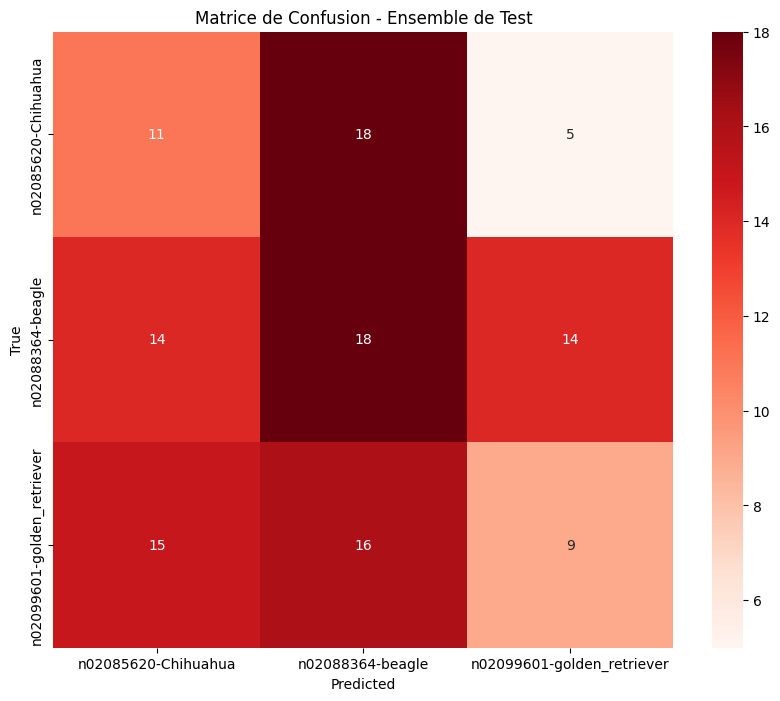

Précision sur le test: 0.9416666626930237


In [ ]:
#Idem mais avec vgg16
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

study_2 = optuna.create_study(direction='maximize')
study_2.optimize(objective, n_trials=10)

# Affichage des meilleurs hyperparamètres
best_params_2 = study_2.best_params
print("Meilleurs hyperparamètres:", best_params_2)
model_3 = Sequential([
    #layers.Lambda(convert_to_grayscale),
    #layers.Lambda(data_standardisation),
    #ayers.Lambda(data_augmentation),
    #Conv2D(64, (best_params['kernel_size'], best_params['kernel_size']), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(best_params_2['dropout_rate']),
    layers.Dense(256, activation='relu'),
    layers.Dropout(best_params_2['dropout_rate']),
    layers.Dense(120, activation='softmax')
])

cnn_from_vgg16 = train_model(model_3,train_ds_sample,val_ds_sample,test_ds_sample,Adam(learning_rate=best_params_2['learning_rate']),'cnn_from_vgg16')


Modèle final

Epoch 1/10
103/103 [==============================] - 1509s 15s/step - loss: 4.9926 - accuracy: 0.0085 - val_loss: 4.7852 - val_accuracy: 0.0099
Epoch 2/10
103/103 [==============================] - 1447s 14s/step - loss: 4.7807 - accuracy: 0.0120 - val_loss: 4.7849 - val_accuracy: 0.0108
Epoch 3/10
103/103 [==============================] - 1456s 14s/step - loss: 4.7811 - accuracy: 0.0120 - val_loss: 4.7869 - val_accuracy: 0.0104
Epoch 4/10
103/103 [==============================] - 1454s 14s/step - loss: 4.7797 - accuracy: 0.0120 - val_loss: 4.7883 - val_accuracy: 0.0101
Epoch 5/10
103/103 [==============================] - 1454s 14s/step - loss: 4.7787 - accuracy: 0.0120 - val_loss: 4.7877 - val_accuracy: 0.0099
Epoch 6/10
103/103 [==============================] - 1455s 14s/step - loss: 4.7786 - accuracy: 0.0120 - val_loss: 4.7865 - val_accuracy: 0.0101
Epoch 7/10
103/103 [==============================] - 1451s 14s/step - loss: 4.7787 - accuracy: 0.0120 - val_loss: 4.7885 - val_ac

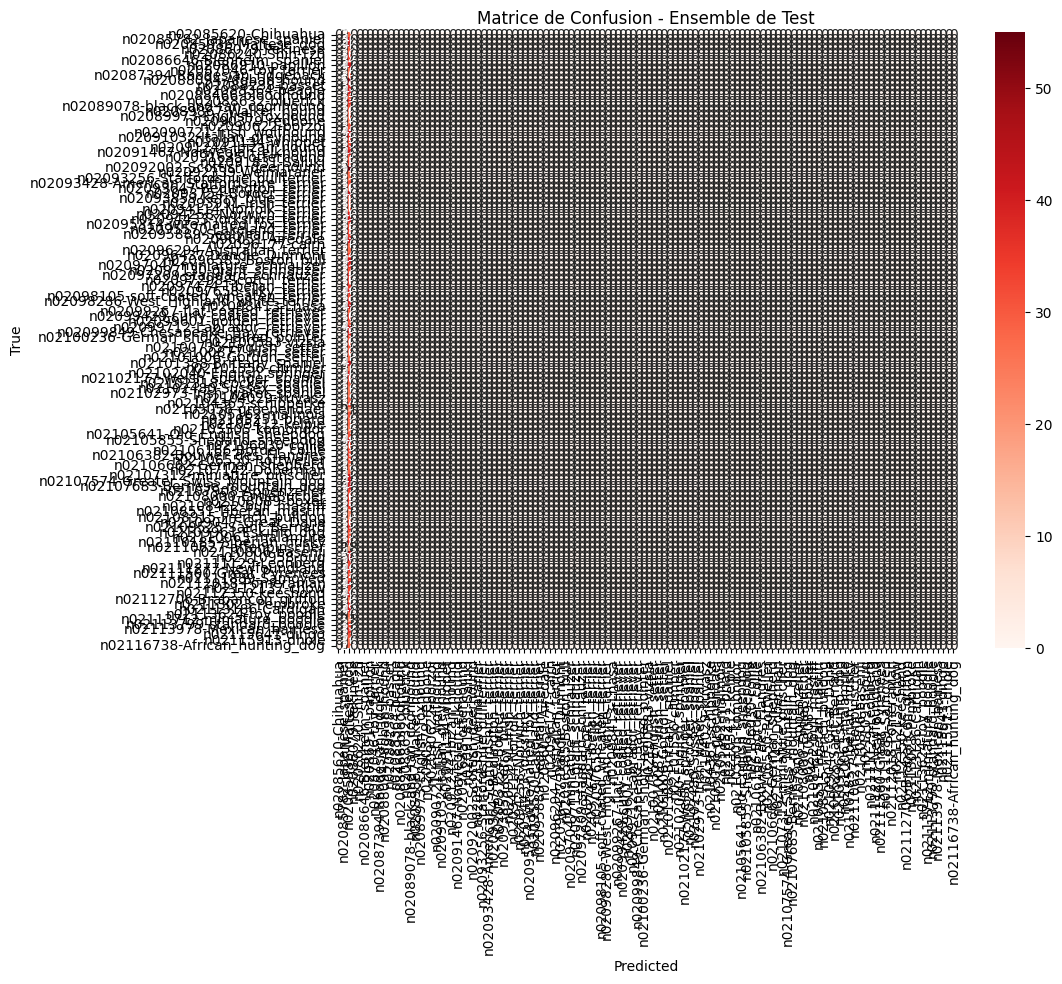

Précision sur le test: 0.012990196235477924


In [ ]:
#Le meilleur lmodèle sur toutes les classes
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Congeler les couches du modèle de base
base_model.trainable = False
mdl_final = train_model(model_3,train_ds,val_ds,test_ds,Adam(learning_rate=best_params['learning_rate']),"mdl_final")
